# Sky background subtraction and aperture photometry
In this lecture, we will see how to compute and subtract the local sky background around the star under analysis, and then we will check how to determine a proper *aperture* to measure the flux of the star



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import pickle
from astropy.io import fits 
%matplotlib widget

We load one scientific frame and the corresponding estimates of the associated error.


In [2]:
science_list = np.genfromtxt('../data/data.list', dtype=str)
science_temp_list = science_list[:10]

# "science_temp_list[0][:-5]": taking the first file of the list without the ".fits"
science_corrected = pickle.load(open('../corrected_files/' + science_temp_list[0][:-5] + '_corr.p', 'rb'))
science_corrected_err = pickle.load(open('../corrected_files/' + science_temp_list[0][:-5] + '_corr_errors.p', 'rb'))


We report here the coordinates of the target measured in the previous step of our analysis. We also prepare the meshgrid arrays and then compute the distance from the centre of our target for each pixel in the frame.

In [3]:
# Refined  coordinates of the target
x_target_refined = 356.98
y_target_refined = 37.66

# Computing again the meshgrid arrays 
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

# 2D array with the distance of each pixel from the target star 
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)



Below, we define a function to plot a circle on the desired coordinates `x_pos, ypos` with radius `radius`, all in pixel units. Optional arguments for the function are: the thickness of the circle expressed in pixel (default `thickness=0.5`), the label associated with the circle (default `label=''`, which means no label), the colour of the circle in [matplotlib standard named colours](https://matplotlib.org/stable/gallery/color/named_colors.html) (default `color='w'`, i.e., white circle), transparency of the circle (default `alpha=1.`, where [alpha](https://matplotlib.org/stable/gallery/color/set_alpha.html) can go from 0. from a completely transparent circle to 1. for a full circle).

Note the use of the numpy functions  [`numpy.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html), [`numpy.outer`](https://numpy.org/doc/stable/reference/generated/numpy.outer.html),  [`numpy.ravel`](https://numpy.org/doc/stable/reference/generated/numpy.ravel.html). Check the documentation by clicking on the corresponding function to get more information about these functions. 


In [4]:
def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)



## Computation of the sky background

To compute the average sky background around our star, we need to define a region of the sensor void of stars or other contaminants. In principle, we could select any region of the frame with these characteristics. However, we should ensure that the sky background level is constant across the frame, which is problematic. A more accessible but still effective approach is to measure the sky background level in a ring, or *annulus*, around our target. If we centre this annulus on the centroid position of our target, we only need to define its *inner radius* and *outer radius* to define it. 

**Inner radius** Since we want to measure the sky background flux, we must be sure that the selected pixels do not contain any flux coming from the target. In other words, the *inner radius* must be large enough to include our star completely, and eventually include some background. 
In the previous lecture, we defined a radius, called `inner_radius`, to select the pixels over which to compute the centroid position of the target star. We can still use this radius if we selected this radius by excluding the star's flux completely, as already anticipated during the previous notebook.

**Outer radius** The outer radius can be as large as you want, but you must be sure that no light from nearby targets enters the annulus. The outer radius should be large enough so that the annulus will include a sufficient number of pixels to determine the average (or median) sky background robustly. 

To ensure that our selection of the `inner_radius` and `outer_radius` satisfy these requirements, we can plot the portion of the frame including our target with a lower value for `vmax`, e.g., using just as twice the `vmin` value, together with two circles representing the inner and outer radii. By doing so, we lose information on the flux distribution near the centre of the star - as all the pixels with flix higher than `vmax` will have the same colour - but we highlight the flux distribution on the wings of the star where the flux coming from the star is comparable with the sky background.

vmin:  857.9    vmax: 1715.9


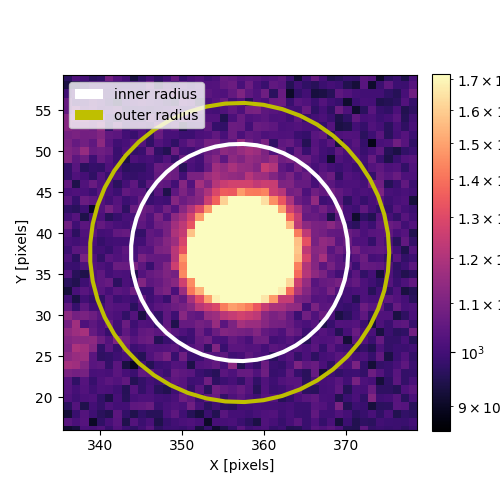

In [5]:
# Value for the inner radius
inner_radius = 13
outer_radius = 18
    
from matplotlib import colors 

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])

vmax = 2*vmin
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-outer_radius*1.2, x_target_refined+outer_radius*1.2)
plt.ylim(y_target_refined-outer_radius*1.2, y_target_refined+outer_radius*1.2)

make_circle_around_star(x_target_refined, y_target_refined, inner_radius, label='inner radius')
make_circle_around_star(x_target_refined, y_target_refined, outer_radius, color='y', label='outer radius')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()


To compute the sky background, we select the pixel within distance from the target `target_distance` between `inner_radius` and `outer_radius`. The array `annulus_selection` is a Boolean array with the same shape as the scientific frame, where every pixel will be `True` if it satisfies the given condition and `False` otherwise.

Since Python interprets `True` as 1.0 and `False` as 0.0 when converting from Boolean to Real, summing over `annulus_selection` will give the number of pixels satisfying the condition. Be sure that this value is higher than 150, to compute the mean and/or the median over a statistically significant sample size of pixels.

The average (or median) over the selected pixels gives the average sky background *per pixel*. 

In [6]:
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)

annular_selection = (target_distance > inner_radius) & (target_distance<=outer_radius)

sky_flux_average = np.sum(science_corrected[annular_selection]) / np.sum(annular_selection)
sky_flux_median = np.median(science_corrected[annular_selection])
print('Number of pixels included in the annulus: {0:7.0f}'.format(np.sum(annular_selection)))
print('Average Sky flux: {0:7.1f} photons/pixel'.format(sky_flux_average)) 
print('Median Sky flux: {0:7.1f} photons/pixel'.format(sky_flux_median)) 


Number of pixels included in the annulus:     484
Average Sky flux:  1016.0 photons/pixel
Median Sky flux:  1015.4 photons/pixel


**HOMEWORK** \
Compute the associated error to the sky background, remembering that every pixel comes with its associated error. \
Are the *median* and *average* consistent within the associated errors? If not, can you identify the cause? \
Based on these results, does using the median or the average make a difference? 

In [7]:
# select the errors of every pixel inside the annular region
sky_flux_annular_err = science_corrected_err[annular_selection]

sky_flux_err_average = np.sum(sky_flux_annular_err)/np.sum(annular_selection)
sky_flux_err_median = np.median(sky_flux_annular_err)

print('Average Sky background error: {0:7.1f} photons/pixel'.format(sky_flux_err_average)) 
print('Median Sky background error: {0:7.1f} photons/pixel'.format(sky_flux_err_median)) 

Average Sky background error:    32.9 photons/pixel
Median Sky background error:    32.9 photons/pixel


## Remove the sky background from the measured flux of the star

The sky background per pixel determined above is only valid in the region surrounding our target star. \
In principle, we should select the frame region from which we want to remove the sky background and perform the computation only on that portion. This approach would be computationally faster, as you have to perform subtraction (and compute the associated error) on fewer pixels. In the end, the calculation on the entire frame is fast enough that the only difference between the two approaches is just on the readability if the code.

**HOMEWORK** \
Compute the error associated to the flux on each pixel after subtracting the sky level.


In [8]:
# Computation on the full frame
science_sky_corrected = science_corrected - sky_flux_average
science_sky_corrected_errors = np.sqrt(science_corrected_err**2. + sky_flux_err_average**2.)

## Aperture photometry 
The basic principle of aperture photometry is to sum up the observed flux within a given region called *aperture*. For our analysis, we will employ a circular aperture, thus defined by the centre of the aperture (corresponding to the centroid of the star) and a radius (the *aperture*),  but in general you can use any shape according to your specific needs, e.g.,  elliptical or isophotal apertures as employed in [SExtractor](https://sextractor.readthedocs.io/en/latest/index.html) for the study of galaxies. 

The choice of the aperture will depend on your specific science case. Here, we want to measure the star's flux, so it sounds reasonable to choose an aperture that contains the totality of the star's flux. In reality, you also have to consider the error associated with the flux of a given pixel. 
Consider a pixel with stellar flux equal to $100$ photons and sky background flux equal to $2000$ photons. The total flux is $2100$ photons, thus the associated error will be approximately $\sqrt{2100} \simeq 50$. This pixel will contribute to the total measurement of the stellar flux by $100 \pm 50$ photons, thus providing a negligible improvement of the flux's measurement.

In conclusion, selecting the aperture including 100% of the star's flux is not necessary. Indeed, most of the time, it is nearly impossible to identify such aperture. In some cases, even an aperture including 80% of the flux may provide the best results. 

In the plot below, we report the measured flux at different apertures, divided by the total flux within the largest meaningful aperture, as a function of the aperture radius.

**HOMEWORK** \
- Identify at least two apertures to perform the photmetric analysis of your star. Later on, you will lear how to compare the two lightcurves and seelct the one with the smaller associated error. You can identify the aperture (on the horizontal axis) by checking the intersection of the horizontal lines (representing different fraction of the total flux) with respect to the measured flux.
- What is the error associated with the absolute value of each flux measurement? Remember that here you are just summing the values of the pixels within the aperture, i.e., you are not performing an average.


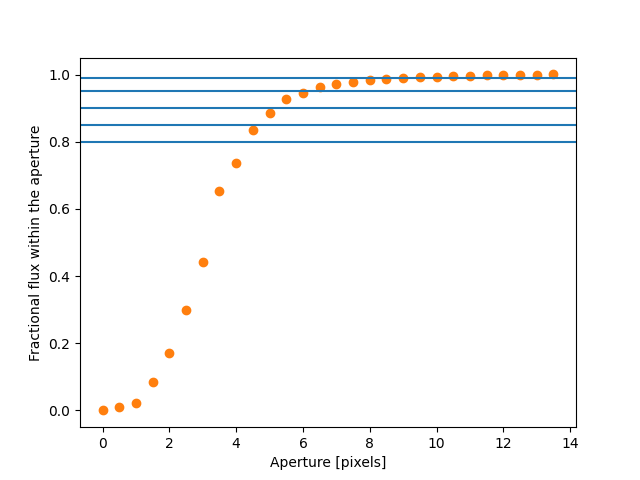

In [9]:
# Cumulative distribution of flux as a function of radius
plt.figure()

inner_selection = (target_distance < inner_radius)
total_flux = np.sum(science_sky_corrected[inner_selection])

radius_array = np.arange(0, inner_radius + 1., 0.5)
flux_vs_radius = np.zeros_like(radius_array)


for ii, aperture_radius in enumerate(radius_array):
    aperture_selection = (target_distance < aperture_radius)
    flux_vs_radius[ii] = np.sum(science_sky_corrected[aperture_selection])/total_flux
    
plt.scatter(radius_array, flux_vs_radius, c='C1')
plt.axhline(0.80)
plt.axhline(0.85)
plt.axhline(0.90)
plt.axhline(0.95)
plt.axhline(0.99)

plt.xlabel('Aperture [pixels]')
plt.ylabel('Fractional flux within the aperture')
plt.show()




## Extra: comparing your star with a multivariate_normal

You may want to check how much the Point Spread Function of your target is departing from a 2D Gaussian shape. This task may keep you busy for weeks, so here we will explore only a qualitative approach. 
The idea behind the next block is to compare the photometry as a function of the aperture radius of two simulated stars with the one measured on the scientific frame. To simulate the star, we use a *multivariate normal* as provided by the [SciPy](https://scipy.org/) package [`scipy.stats.multivariate_normal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), assuming an axisymmetric distribution with respect to the centre of the multivariate normal. Here, the Probability Distribution Function `pdf` will produce our image. Note the use of the numpy function [`numpy.dstack`](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html).

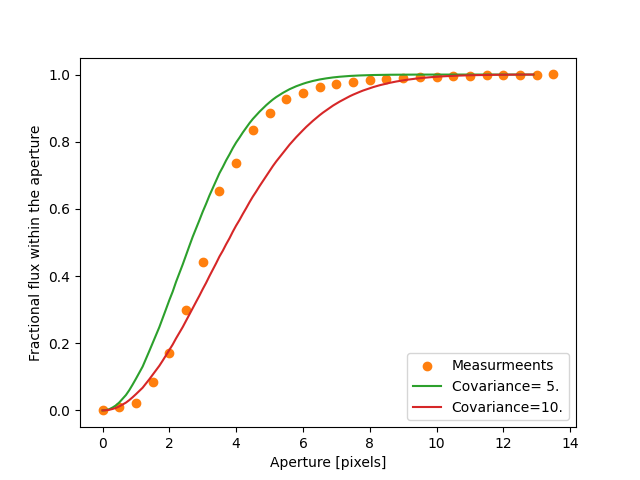

In [10]:
from scipy.stats import multivariate_normal

xy_range = np.arange(-inner_radius*1.2, inner_radius*1.2, 0.1)
X_gauss, Y_gauss= np.meshgrid(xy_range, xy_range)

pos = np.dstack((X_gauss, Y_gauss))


gauss_distance =np.sqrt((X_gauss)**2 + (Y_gauss)**2)

plot_range = np.arange(0, inner_radius, 0.1)

# Let's compare two different values for the covarince:

mv_normal_cov05 = multivariate_normal(mean=[0., 0.], cov=5., allow_singular=False)
mv_normal_cov05_pdf = mv_normal_cov05.pdf(pos)
plot_cov05_flux = np.zeros_like(plot_range)

mv_normal_cov10 = multivariate_normal(mean=[0., 0.], cov=10., allow_singular=False)
mv_normal_cov10_pdf = mv_normal_cov10.pdf(pos)
plot_cov10_flux = np.zeros_like(plot_range)


for ii, aperture_radius in enumerate(plot_range):

    pdf_selection = (gauss_distance < aperture_radius)
    plot_cov05_flux[ii] =   np.sum(mv_normal_cov05_pdf[pdf_selection])
    plot_cov10_flux[ii] =   np.sum(mv_normal_cov10_pdf[pdf_selection])



plt.figure()
plt.scatter(radius_array, flux_vs_radius, c='C1', label='Measurmeents')
plt.plot(plot_range,plot_cov05_flux/plot_cov05_flux[-1] , c='C2', label='Covariance= 5.')
plt.plot(plot_range,plot_cov10_flux/plot_cov10_flux[-1] , c='C3', label='Covariance=10.')

plt.xlabel('Aperture [pixels]')
plt.ylabel('Fractional flux within the aperture')
plt.legend()

plt.show()

